In [173]:
import time

import matplotlib as plt
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np
# import seaborn as sns

from selenium.webdriver.chrome.service import Service
# from webdriver_manager.chrome import ChromeDriverManager
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
def data_collect():
    s = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=s)
    driver.maximize_window()
    #driver.get('https://www.google.com')
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    # , options=chrome_options
    
    # driver = webdriver.Chrome("C:/Users/yuval/Desktop/Shahar/Data-science-Weather/chromedriver/chromedriver", options=chrome_options)
    # C:/Users/yuval/Desktop/Shahar/Data-science-Weather/chromedriver/chromedriver --> Shahar
    # /Users/gal.bachar/git_wa/HIT/Data-science-Weather/chromedriver/chromedriver  --> Gal
    df = pd.DataFrame([], columns=["year", "month", "day", "temp","temp min","temp max","dew point", "humidity", "windspeed", "windspeed min", "windspeed max", "precipitation"])
    df_row_count=1

    # switch temp from fahrenheit to celsius
    driver.get(f"https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/1950-1")
    time.sleep(2)
    settings = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "wuSettings")))
    settings.click()
    time.sleep(2)
    celsius = WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.XPATH,'//*[@id="wuSettings-quick"]/div/a[2]')))
    celsius.click()

    for year in range(1950,2023):
        for month in range(1,13):
            try:
                driver.get(f"https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/{year}-{month}")
                print(f'{month}-{year}')
            except Exception as e:
                print(f'{e} - unable to get: {month}.{year}')
            try:
                table_id= WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "days")))
                data = table_id.find_elements(By.TAG_NAME, "table") # get all of the rows in the table
                num_of_days = len(data[1].find_elements(By.TAG_NAME, "tr"))

                for i in range(1,num_of_days):
                    day = int(data[0].find_elements(By.TAG_NAME, "tr")[i].text)
                    temp = float(data[1].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    temp_min = float(data[1].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[2])
                    temp_max = float(data[1].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[0])
                    dew_point = float(data[2].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    humidity = float(data[3].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    windspeed = float(data[4].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    windspeed_min = float(data[4].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[2])
                    windspeed_max = float(data[4].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[0])
                    precipitation = float(data[6].find_elements(By.TAG_NAME, "tr")[i].text)
                    day_data = [year,month,day,temp,temp_min,temp_max,dew_point,humidity,windspeed,windspeed_min,windspeed_max,precipitation]
                    df.loc[df_row_count] = day_data
                    df_row_count += 1
            except Exception as e:
                print(f"cloud not get {year}-{month} data: {e}")

    driver.quit()
    df.to_csv('~/Documents/nyc_weather.csv',index=False) #for debugging
    return df

In [175]:
def normalize_data(data_df, good_weather_values):
    norm_df = data_df.copy()

    for i in norm_df.columns:
        if i not in ['year', 'month', 'day',"temp min","temp max", "windspeed min", "windspeed max","dew point"]:
            good_min = good_weather_values[i][0]
            good_max = good_weather_values[i][1]
            diff_min = good_weather_values[i][0] - norm_df[i].min()
            diff_max = norm_df[i].max() - good_weather_values[i][1]
            norm_df.loc[(norm_df[i] < good_min), i] = 1 - ((good_min - norm_df[i]) / diff_min)
            norm_df.loc[(norm_df[i] > good_max), i] = 1 - ((norm_df[i] - good_max) / diff_max)
            norm_df.loc[(norm_df[i] <= good_max) & (norm_df[i] >= good_min), i] = 1
    norm_df.insert(7, "pleasant day", 0)
    
    norm_df.loc[(norm_df["temp"] != 0),"pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"] + norm_df["precipitation"]) / 4
    norm_df.loc[(norm_df["temp"] != 0) & (norm_df["precipitation"].isna()), "pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"]) / 3
    # norm_df.loc[(norm_df["temp"] < 0),"pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"] + norm_df["precipitation"]) / 4

    # norm_df.loc["pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"] + norm_df["precipitation"]) / 4
    # norm_df.loc[(norm_df["precipitation"].isna()), "pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"]) / 3

    return norm_df

In [176]:
def remove_missing_data(data):
    data.loc[data["year"] <= 2014, "precipitation"] = np.NaN
    return data

In [177]:
def num_of_good_days_per_month(data):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    months=['Jan', 'Feb','Mar','Apr','May','jun','Jul','Aug','Sep','Oct','Nov','Dec']
    res = {}
    for i in range(0,12):
        res[months[i]] = len(data.loc[(data['month'] == (i+1)) & (data['pleasant day'] >= 0.9)])
    ser = pd.Series(res)
    # print(ser)
    ser.plot(kind='pie', ax=axes[0], title = "All time good days per month")
    ser.plot(kind='line', ax=axes[1], title = "Pleasent days per month")

In [178]:
def num_of_good_days_trends(data):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    months=['Jan', 'Feb','Mar','Apr','May','jun','Jul','Aug','Sep','Oct','Nov','Dec']
    res = {}
    for j in range(1950,2022):
        for i in range(0,12):
            #print(data.loc[((data['month'] == (i+1)) & (data['year'] == j)),'pleasant day'].mean())
            res[f"{i + 1}-{j}"] = round(data.loc[((data['month'] == (i+1)) & (data['year'] == j)),'pleasant day'].mean(),2)
    ser = pd.Series(res)
    # print(ser)
    ser.plot(kind='line', ax=axes[0], title = "Mean good days per month")

    ser2 = pd.Series(data["pleasant day"])
    # print(ser)
    ser2.plot(kind='line', ax=axes[1], title = "Pleasant days values over the time")

In [179]:
def num_of_good_days(data):
    fig, axes = plt.subplots(1, 1, figsize=(20, 5))
    ser = pd.Series(data["pleasant day"])
    # print(ser)
    ser.plot(kind='line', ax=axes, title = "Pleasant days values over the time")

In [180]:
def get_highly_correlated_cols(data):
    col_correlated = set()
    tuple_array = []
    correlations = []
    for i in range (len(data.corr().columns)):
        for j in range(i):
            if(data.corr().iloc[j, i] >= 0.5) and (data.corr().columns[i] not in col_correlated):
                correlations.append(data.corr().iloc[i, j])
                tuple_array.append([j, i])
    return correlations, tuple_array

In [181]:
def high_correlated_scatters(data):
    fig, axes = plt.subplots(len(correlations), 1, figsize = (10, 12),constrained_layout=True)
    axe_i = 0
    index = np.argsort(correlations)
    columns = list(data.columns)
    for n_correlation in index:
        col_lt, col_rt = tuple_arr[n_correlation]
        col_left_title, col_right_title = columns[col_lt], columns[col_rt]
        title = "corr('%s', '%s') = %4.2f" % (col_left_title, col_right_title, correlations[n_correlation])
        data.plot(x = col_left_title, y = col_right_title, kind = "scatter",
                ax = axes[axe_i], title = title, xlabel = col_left_title, ylabel = col_right_title)
        axe_i = axe_i + 1

In [182]:
def remove_corrupt_rows(df, num_max_missing_cols):
    cp = df.dropna(thresh=len(df.columns)-num_max_missing_cols).copy()
    return cp

In [183]:
def getOutliers(df):
    cp = df.copy()
    all_outliers = {}
    fig, axes = plt.subplots(1, len(cp.columns) - 3, figsize = (30, 5))
    axe_i = 0
    for col in cp.columns:
        if col in ["humidity"]:
            z_score_value=2.5
        else:
            z_score_value=3
        if col not in ["year", "month", "day"]:    
            #plt.hist(df[col],bins=50, ax=axes[axe_i])
            ax = cp[col].plot(bins=50, ax=axes[axe_i], kind="hist")
            axe_i = axe_i + 1
            ax.set(xlabel=col)
            plt.ylabel("Frequency")
            # looking for outliers using distances of standard deviation from the mean.
            z_score = (cp[col] - cp[col].mean()) / cp[col].std()
            
            outliers = abs(z_score) > z_score_value # after some tests if we will search for lower distance we will lost important information.
            print (f"Number of outliers for {col} - {sum(outliers)}")
            all_outliers[col] = outliers

    
    return all_outliers


In [184]:
def putNanOutliers(df, all_outliers):
    cp = df.copy()
    for key in all_outliers:
        cp.loc[all_outliers[key].tolist(),key] = np.NaN
    return cp

In [199]:
def showOutliers(all_outliers):
    fig, axes = plt.subplots(1, len(df.columns) - 3, figsize = (30, 5))
    axe_i = 0
    for col in all_outliers:
        ser = pd.Series(df.loc[all_outliers[col],col])
        ser.plot(kind="hist", ax=axes[axe_i], title = f"Outliers for {col}")
        axe_i = axe_i + 1

In [186]:
def getArray(data):
    arr = []
    for i in range(0,len(data)):
        arr.append(data[i])
    return arr

In [187]:
def graphOverTime(df,param):
    colors=["r","b","g","black"]
    i=0
    for col in param:
        c=colors[i]
        i=i+1
        df.plot(x="year", y=[col],figsize=(15, 7), grid=True,color=c)

In [188]:
# nice weather:
# temp 18-25
# humidity 30-50%
# windspeed 0-7
# precipitation 0 - 0.5
good_weather_values = {'temp': [20,23], 'humidity':[30,40],'windspeed':[4,7], 'precipitation':[0,1]}
# df = data_collect()
df = pd.read_csv('~/Documents/nyc_weather.csv') # for debugging
# norm_df = normalize_data(fixed_data, good_weather_values)
print ("Done")

Done


In [189]:
print("All data")
df

All data


,year,month,day,temp,temp min,temp max,dew point,humidity,windspeed,windspeed min,windspeed max,precipitation
0,1950.0,1.0,1.0,3.8,0.0,6.0,-6.0,49.8,9.8,4.0,20.0,0.00
1,1950.0,1.0,2.0,4.9,4.0,6.0,1.6,80.1,11.4,6.0,17.0,0.00
2,1950.0,1.0,3.0,10.5,6.0,14.0,8.6,88.1,14.3,4.0,22.0,0.00
3,1950.0,1.0,4.0,15.7,10.0,19.0,12.0,78.6,21.3,6.0,33.0,0.00
4,1950.0,1.0,5.0,13.5,8.0,18.0,10.6,82.6,15.3,7.0,31.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
26325,2022.0,5.0,28.0,20.6,18.0,25.0,16.1,75.6,13.0,0.0,26.0,7.11
26326,2022.0,5.0,29.0,20.8,17.0,26.0,11.4,57.0,8.9,0.0,26.0,3.81
26327,2022.0,5.0,30.0,24.3,19.0,29.0,14.9,57.0,12.9,0.0,28.0,0.00
26328,2022.0,5.0,31.0,27.4,18.0,33.0,15.4,50.8,18.5,6.0,31.0,0.00


In [190]:
print("Dataframe describe")
df.describe(include="all")

Dataframe describe


,year,month,day,temp,temp min,temp max,dew point,humidity,windspeed,windspeed min,windspeed max,precipitation
count,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000,26330.000000
mean,1985.757463,6.501101,15.718610,12.506905,7.773224,16.518078,5.085454,61.409464,18.899290,8.006722,30.562134,0.366952
std,20.919567,3.457508,8.801684,9.398341,9.362154,10.098990,9.926753,13.800244,6.598554,6.508075,9.519212,3.255206
min,1950.000000,1.000000,1.000000,-16.200000,-19.000000,-13.000000,-24.800000,21.100000,3.200000,0.000000,6.000000,0.000000
25%,1968.000000,3.000000,8.000000,5.000000,0.000000,8.000000,-2.400000,51.100000,14.200000,2.000000,24.000000,0.000000
50%,1986.000000,7.000000,16.000000,12.600000,7.000000,17.000000,5.600000,60.200000,17.800000,7.000000,30.000000,0.000000
75%,2004.000000,10.000000,23.000000,20.700000,16.000000,25.000000,13.500000,70.700000,22.500000,11.000000,35.000000,0.000000
max,2022.000000,12.000000,31.000000,34.400000,31.000000,52.000000,24.800000,100.000000,65.500000,50.000000,115.000000,174.240000


Number of outliers for temp - 2
Number of outliers for temp min - 0
Number of outliers for temp max - 1
Number of outliers for dew point - 1
Number of outliers for humidity - 115
Number of outliers for windspeed - 277
Number of outliers for windspeed min - 220
Number of outliers for windspeed max - 253
Number of outliers for precipitation - 327


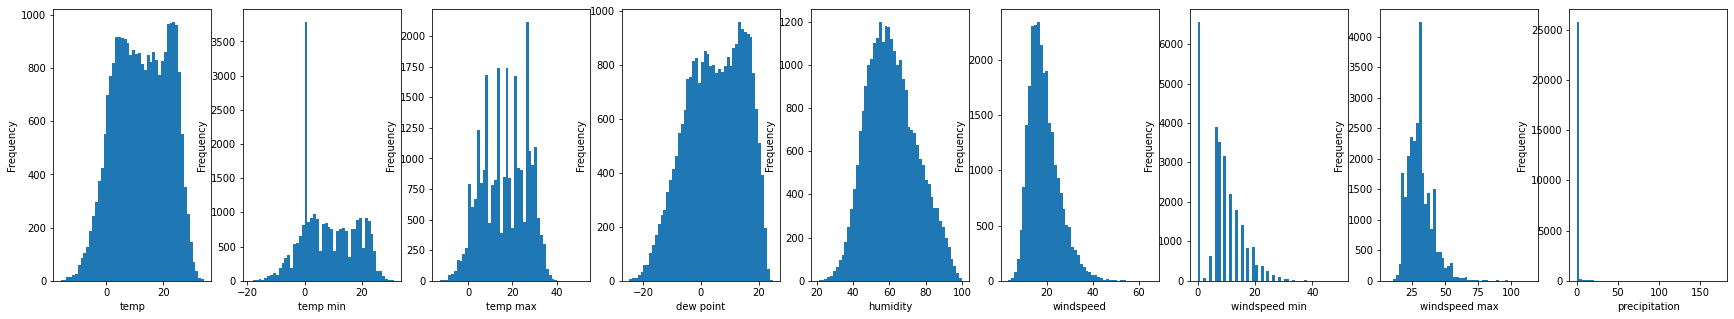

In [191]:
# EDA

all_outliers = getOutliers(df)
fixed_data = remove_missing_data(df)
noOut = putNanOutliers(fixed_data,all_outliers)

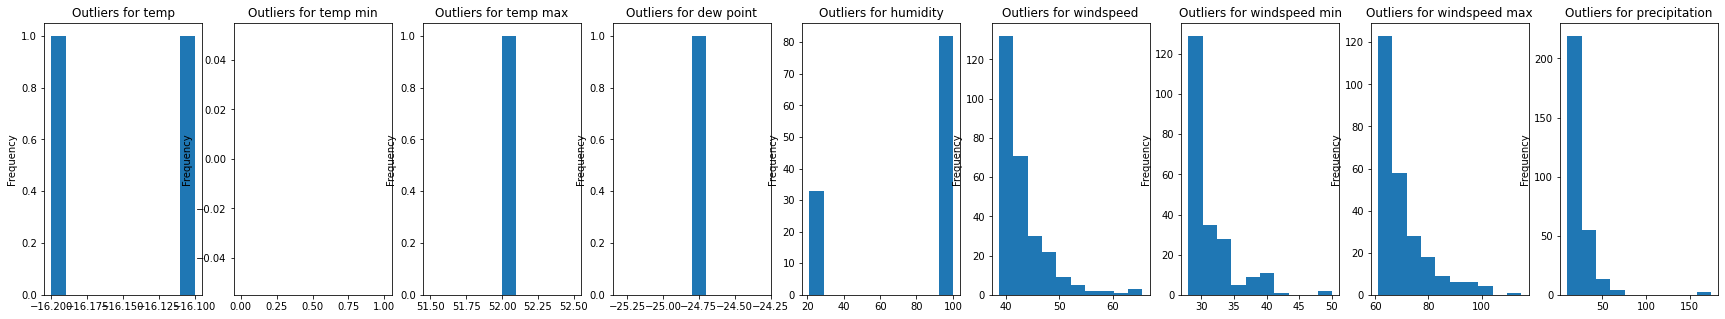

In [200]:
# Show outliers
showOutliers(all_outliers)

In [193]:
df_no_outliers = remove_corrupt_rows(noOut, 2)
print("Full DataFrame")
print(df.shape)
print("No outliers DataFrame")
print(df_no_outliers.shape)

Full DataFrame
(26330, 12)
No outliers DataFrame
(26130, 12)


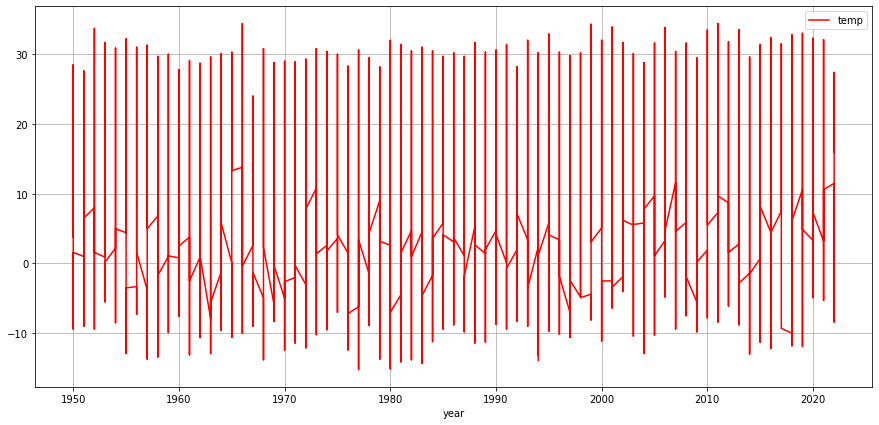

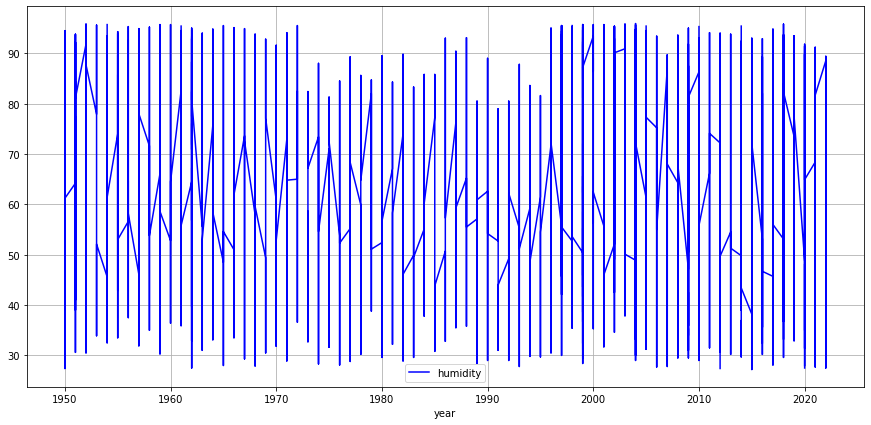

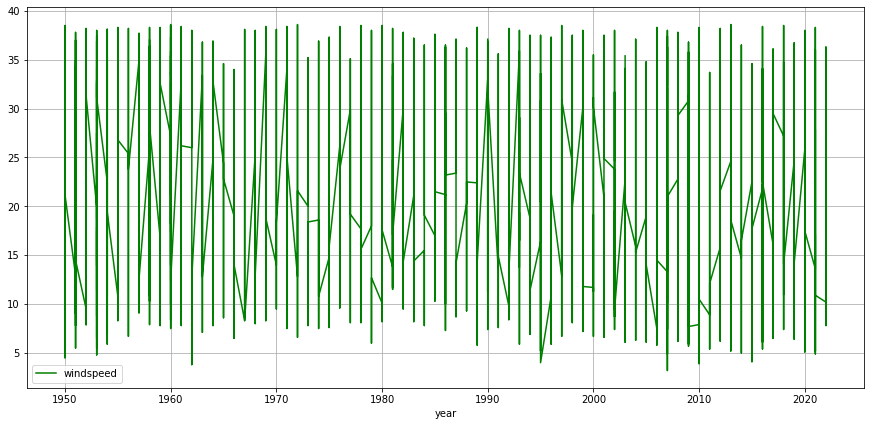

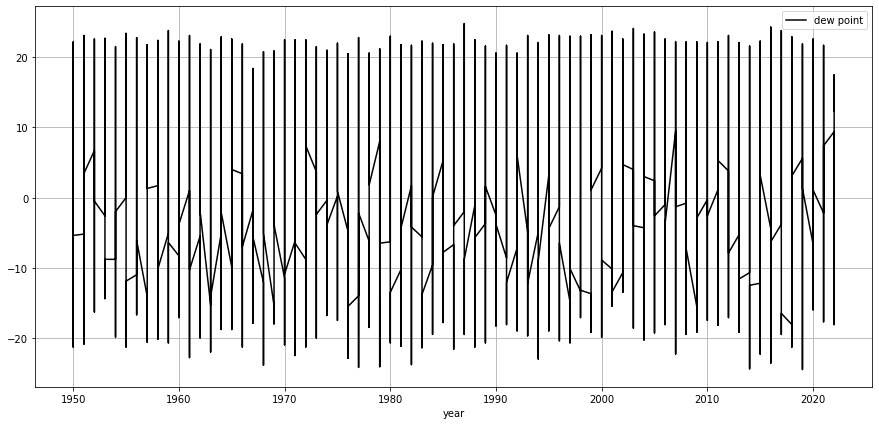

In [194]:
param = ["temp","humidity","windspeed","dew point"]
graphOverTime(df_no_outliers,param)

In [195]:
norm_df = normalize_data(df_no_outliers, good_weather_values)
print("All data - normalized")
# fixed_data
norm_df

All data - normalized


,year,month,day,temp,temp min,temp max,dew point,pleasant day,humidity,windspeed,windspeed min,windspeed max,precipitation
0,1950.0,1.0,1.0,0.539773,0.0,6.0,-6.0,0.758617,0.824687,0.911392,4.0,20.0,NaN
1,1950.0,1.0,2.0,0.571023,4.0,6.0,1.6,0.571477,0.282648,0.860759,6.0,17.0,NaN
2,1950.0,1.0,3.0,0.730114,6.0,14.0,8.6,0.546212,0.139535,0.768987,4.0,22.0,NaN
3,1950.0,1.0,4.0,0.877841,10.0,19.0,12.0,0.578263,0.309481,0.547468,6.0,33.0,NaN
4,1950.0,1.0,5.0,0.815341,8.0,18.0,10.6,0.596869,0.237925,0.737342,7.0,31.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26325,2022.0,5.0,28.0,1.000000,18.0,25.0,16.1,0.793319,0.363148,0.810127,0.0,26.0,1.0
26326,2022.0,5.0,29.0,1.000000,17.0,26.0,11.4,0.908940,0.695886,0.939873,0.0,26.0,1.0
26327,2022.0,5.0,30.0,0.885965,19.0,29.0,14.9,0.848785,0.695886,0.813291,0.0,28.0,1.0
26328,2022.0,5.0,31.0,0.614035,18.0,33.0,15.4,0.764227,0.806798,0.636076,6.0,31.0,1.0


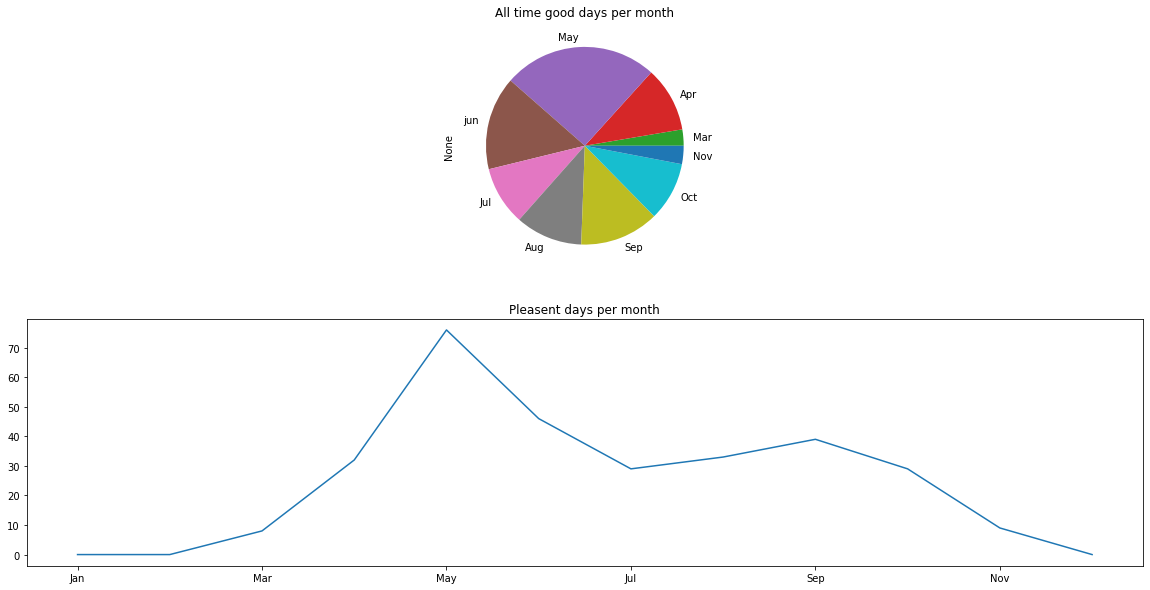

In [196]:
num_of_good_days_per_month(norm_df)

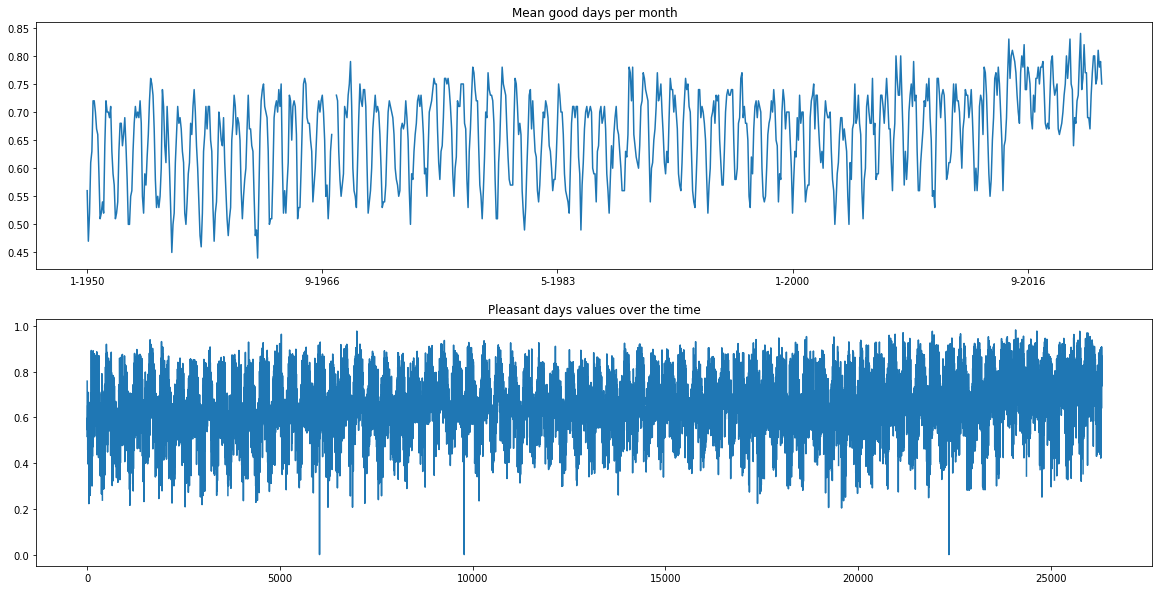

In [197]:
num_of_good_days_trends(norm_df)
# num_of_good_days(norm_df)

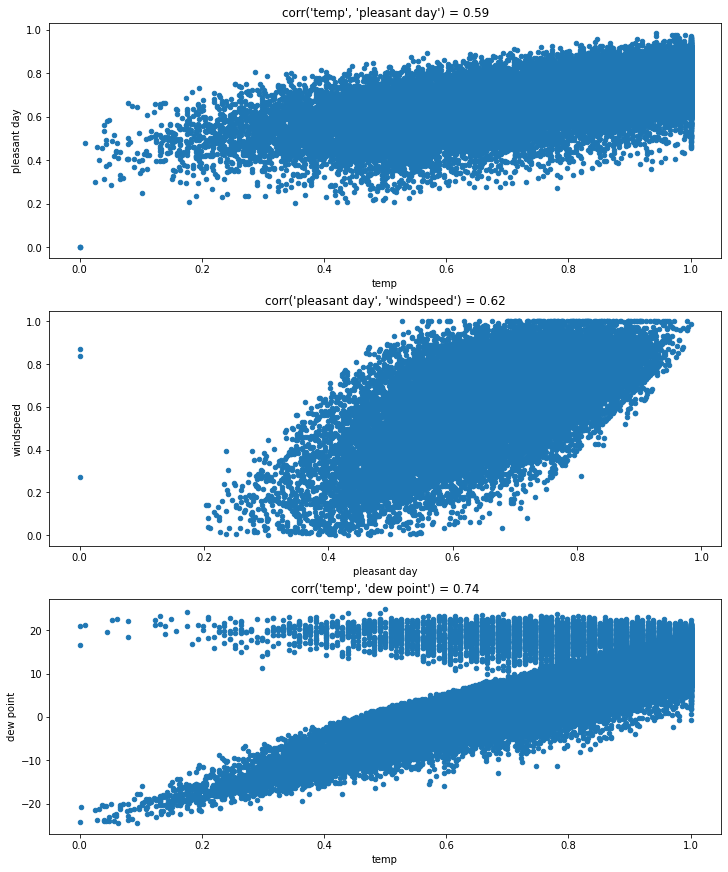

In [198]:
corr_df = norm_df.drop(columns=['temp min','temp max','windspeed min','windspeed max'])

correlations, tuple_arr = get_highly_correlated_cols(corr_df)
high_correlated_scatters(corr_df)

In [ ]:
def get_df_target_col(df):
    y= df['pleasant day']
    df.drop('pleasant day',axis=1,inplace=True)
    return df,y

def train_1st_model(X_train, y_train):
    reg=LinearRegression()
    
    return reg.fit(X_train,y_train)
def predict_1st(trained_1st_model, X_test):
    predict=trained_1st_model.predict(X_test)
    return predict

In [ ]:
train, test = train_test_split(norm_df, test_size=0.2)

X_1st_train, y_1st_train = get_df_target_col(train)
X_1st_test, y_1st_test = get_df_target_col(test)
trained_model_1st = train_1st_model(X_1st_train, y_1st_train)
pred_1st_vals = predict_1st(trained_model_1st, X_1st_test)
print(len(pred_1st_vals),len(y_1st_test))